In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point
import folium
from folium.plugins import HeatMap

In [4]:
df = pd.read_csv('data/CA_LA_subset.csv')
print(df.head())

        ID   Source  Severity           Start_Time             End_Time  \
0  A-42867  Source2         2  2016-06-21 10:46:30  2016-06-21 11:27:00   
1  A-42868  Source2         3  2016-06-21 10:49:21  2016-06-21 11:34:21   
2  A-42882  Source2         3  2016-06-21 10:51:45  2016-06-21 11:36:45   
3  A-42884  Source2         3  2016-06-21 10:56:24  2016-06-21 11:34:00   
4  A-42899  Source2         3  2016-06-21 11:30:46  2016-06-21 12:00:46   

   Start_Lat   Start_Lng  End_Lat  End_Lng  Distance(mi)  ... Roundabout  \
0  34.078926 -118.289040      NaN      NaN           0.0  ...      False   
1  34.091179 -118.239471      NaN      NaN           0.0  ...      False   
2  34.037239 -118.309074      NaN      NaN           0.0  ...      False   
3  34.027458 -118.274490      NaN      NaN           0.0  ...      False   
4  33.947544 -118.279434      NaN      NaN           0.0  ...      False   

  Station   Stop Traffic_Calming Traffic_Signal Turning_Loop Sunrise_Sunset  \
0   False  Fa

Accidents Heatmap

In [ ]:
sample_df = df[['Start_Lat', 'Start_Lng']].dropna()
m = folium.Map(location=[34.05, -118.25], zoom_start=10)

# Add HeatMap layer
HeatMap(data=sample_df.values, radius=8).add_to(m)
m.save('accident_heatmap.html')


In [6]:
df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-42867,Source2,2,2016-06-21 10:46:30,2016-06-21 11:27:00,34.078926,-118.289040,NaN,NaN,0.0,...,False,False,False,False,False,False,Day,Day,Day,Day
1,A-42868,Source2,3,2016-06-21 10:49:21,2016-06-21 11:34:21,34.091179,-118.239471,NaN,NaN,0.0,...,False,False,False,False,False,False,Day,Day,Day,Day
2,A-42882,Source2,3,2016-06-21 10:51:45,2016-06-21 11:36:45,34.037239,-118.309074,NaN,NaN,0.0,...,False,True,False,False,False,False,Day,Day,Day,Day
3,A-42884,Source2,3,2016-06-21 10:56:24,2016-06-21 11:34:00,34.027458,-118.274490,NaN,NaN,0.0,...,False,False,False,False,False,False,Day,Day,Day,Day
4,A-42899,Source2,3,2016-06-21 11:30:46,2016-06-21 12:00:46,33.947544,-118.279434,NaN,NaN,0.0,...,False,False,False,False,False,False,Day,Day,Day,Day


In [7]:
### This is the same code from "convert_time.ipynb" slighty adjusted ###

# Convert the 'Start_Time' column to datetime format, handling mixed formats while keeping 'Start Lat' and 'Start Lng' as strings
df['Start_Time'] = pd.to_datetime(df['Start_Time'], format='mixed')
# Extract the hour from the 'Start_Time' column
df['Start_hour'] = df['Start_Time'].dt.hour
# Create a new DataFrame which contains the unique starts of hours and the date
# Extract the date from the 'Start_Time' column
df['Start_date'] = df['Start_Time'].dt.date
# Create a new DataFrame with unique combinations of date and hour
df['Start_hour'] = df['Start_hour'].astype(int)
# Drop duplicates to get unique combinations of date and hour
unique_starts = df[['Start_date', 'Start_hour','Start_Lat','Start_Lng','Visibility(mi)']].drop_duplicates()
unique_starts.index = range(len(unique_starts))
#maximum date
max_date = unique_starts['Start_date'].max()
max_hour = unique_starts['Start_hour'].max()
min_date = unique_starts['Start_date'].min()
min_hour = unique_starts['Start_hour'].min()
print(f"Max date: {max_date}, Max hour: {max_hour}")
print(f"Min date: {min_date}, Min hour: {min_hour}")
unique_starts

weather_data = pd.read_csv('data/weather_data.csv')
# convert the 'datetime' column to two columns: 'date' and 'hour'
weather_data['date'] = pd.to_datetime(weather_data['datetime']).dt.date
weather_data['hour'] = pd.to_datetime(weather_data['datetime']).dt.hour
# Drop the original 'datetime' column
weather_data = weather_data.drop(columns=['datetime'])

# Connect the two dataframes on the date and hour columns only if the date exists in the unique_starts
# Merge the unique_starts DataFrame with the weather_data DataFrame
merged_data = pd.merge(unique_starts, weather_data, left_on=['Start_date', 'Start_hour'], right_on=['date', 'hour'], how='left')
merged_data.drop(columns=['date', 'hour'], inplace=True)
merged_data.to_csv('merged_data.csv', index=False)
merged_data.head()

Max date: 2023-03-31, Max hour: 23
Min date: 2016-03-22, Min hour: 0


,Start_date,Start_hour,Start_Lat,Start_Lng,Visibility(mi),name,temp,feelslike,dew,humidity,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,2016-06-21,10,34.078926,-118.289040,10.0,Los Angeles,26.4,26.4,15.4,50.95,...,1014.3,2.9,15.9,680.0,2.4,7.0,NaN,Clear,clear-day,"KHHR,72295023174,KBUR,72295603167,72288023152,..."
1,2016-06-21,10,34.091179,-118.239471,10.0,Los Angeles,26.4,26.4,15.4,50.95,...,1014.3,2.9,15.9,680.0,2.4,7.0,NaN,Clear,clear-day,"KHHR,72295023174,KBUR,72295603167,72288023152,..."
2,2016-06-21,10,34.037239,-118.309074,10.0,Los Angeles,26.4,26.4,15.4,50.95,...,1014.3,2.9,15.9,680.0,2.4,7.0,NaN,Clear,clear-day,"KHHR,72295023174,KBUR,72295603167,72288023152,..."
3,2016-06-21,10,34.027458,-118.274490,10.0,Los Angeles,26.4,26.4,15.4,50.95,...,1014.3,2.9,15.9,680.0,2.4,7.0,NaN,Clear,clear-day,"KHHR,72295023174,KBUR,72295603167,72288023152,..."
4,2016-06-21,11,33.947544,-118.279434,10.0,Los Angeles,28.0,28.2,15.7,47.33,...,1014.1,2.9,15.9,811.9,2.9,8.0,NaN,Clear,clear-day,"KHHR,72295023174,KBUR,72295603167,72288023152,..."


In [8]:
for condition in merged_data['conditions'].unique():
    plot_df = merged_data[merged_data["conditions"] == condition][['Start_Lat', 'Start_Lng']].dropna()
    print(f"{condition} Samples", len(plot_df))
    m = folium.Map(location=[34.05, -118.25], zoom_start=10)
    HeatMap(data=plot_df.values, radius=8).add_to(m)
    m.save(f'Visualizations/accident_heatmap_{condition}.html')


Clear Samples 100665
Partially cloudy Samples 15597
Overcast Samples 17323
Rain Samples 119
Rain, Overcast Samples 5551
Rain, Partially cloudy Samples 2073
nan Samples 0


In [9]:
merged_data.columns

Index(['Start_date', 'Start_hour', 'Start_Lat', 'Start_Lng', 'Visibility(mi)',
       'name', 'temp', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'preciptype', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
       'solarenergy', 'uvindex', 'severerisk', 'conditions', 'icon',
       'stations'],
      dtype='object')

In [ ]:
import routing_utils as ru

G = ru.load_graph()
print("Done loading graph")

counter = 0
counter_all = 0
road_types = []
for u, v, key, data in G.edges(keys=True, data=True):
    counter_all += 1
    #print(f"Edge {u} to {v} with key {key} has data: {data}")
    if data["highway"] not in road_types:
        road_types.append(data["highway"])
    if data["highway"] == "motorway":
        counter += 1

#print("Fraction of motorways in the graph: ", counter/counter_all)
print("Road Types: ",road_types)

for road_type in road_types:
    print(f"Road Type: {road_type}")
    counter = 0
    for u, v, key, data in G.edges(keys=True, data=True):
        if data["highway"] == road_type:
            counter += 1
    print(f"Fraction of {road_type} in the graph: ", counter/counter_all)

Done loading graph
Road Types:  ['secondary', 'primary', 'tertiary', 'motorway', 'residential', 'motorway_link', 'secondary_link', 'unclassified', ['unclassified', 'residential'], 'primary_link', 'busway', ['residential', 'tertiary'], ['unclassified', 'tertiary'], ['unclassified', 'secondary_link'], ['motorway', 'motorway_link'], 'trunk_link', 'tertiary_link', ['secondary', 'motorway_link'], 'trunk', ['secondary', 'residential'], ['residential', 'secondary'], ['secondary', 'primary'], 'living_street', ['secondary', 'tertiary'], ['primary_link', 'residential'], ['unclassified', 'secondary']]
Road Type: secondary
Fraction of secondary in the graph:  0.11151795236402418
Road Type: primary
Fraction of primary in the graph:  0.07790615001777462
Road Type: tertiary
Fraction of tertiary in the graph:  0.12470671880554568
Road Type: motorway
Fraction of motorway in the graph:  0.006943950705059841
Road Type: residential
Fraction of residential in the graph:  0.6473278824505273
Road Type: motor

# Overlay Maps

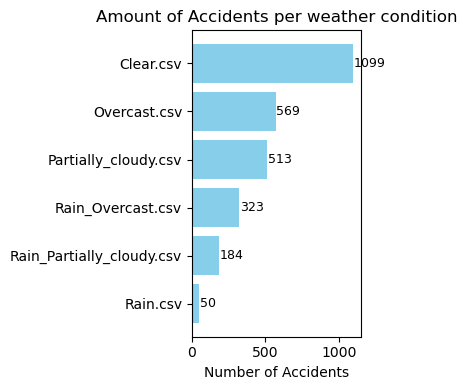

In [ ]:
file_counts = {}
for filename in os.listdir('risk_maps'):
    if filename.endswith('.csv'):
        file_path = os.path.join('risk_maps', filename)
        try:
            df = pd.read_csv(file_path)
            file_counts[filename] = len(df)
        except Exception as e:
            print(f"Failed to read {filename}: {e}")

count_df = pd.DataFrame(list(file_counts.items()), columns=['File', 'Row Count'])
count_df.sort_values('Row Count', ascending=True, inplace=True)  # Ascending so smallest at bottom

# Plot horizontal bars
plt.figure(figsize=(4, 4))
bars = plt.barh(count_df['File'], count_df['Row Count'], color='skyblue')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 5, bar.get_y() + bar.get_height()/2, f'{int(width)}',
             ha='left', va='center', fontsize=9)

plt.xlabel('Number of Accidents')
plt.title('Amount of Accidents per weather condition')
plt.tight_layout()
plt.savefig('Visualizations/accidents_per_condition_vertical_bar.png', dpi=300)
plt.show()

In [ ]:
weather_colors = {
    'Clear': 'blue',
    'Rain': 'red',
    'Rain_Overcast': 'purple',
    'Partially_cloudy': 'orange',
    'Overcast': 'yellow',
    'Rain_Partially_cloudy': 'green'
}

m = folium.Map(location=[34.05, -118.25], zoom_start=10)

# Add toggleable layers per condition
for condition in merged_data['conditions'].unique():
    color = weather_colors.get(condition, 'black')
    plot_df = merged_data[merged_data["conditions"] == condition][['Start_Lat', 'Start_Lng']].dropna()
    print(f"{condition} Samples:", len(plot_df))

    #sample = plot_df.sample(n=min(6000, len(plot_df)), random_state=42)    # Sample 6000 points for easiere computation of visualization
    sample = plot_df                                                        # Use all data for the condition

    fg = folium.FeatureGroup(name=condition)

    for _, row in sample.iterrows():
        folium.CircleMarker(
            location=[row['Start_Lat'], row['Start_Lng']],
            radius=6,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.2,
            weight=0.5
        ).add_to(fg)

    fg.add_to(m)

# Add Layer Control
folium.TileLayer(titles = "Stamen Terrain").add_to(m)
folium.TileLayer("CartoDB Positron").add_to(m)
folium.TileLayer("openstreetmap").add_to(m)
folium.LayerControl().add_to(m)


legend_html = '''
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 220px; height: 220px; 
     background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
     padding: 10px;">
     <b>Weather Legend</b><br>
     <i style="background: blue; width: 10px; height: 10px; display: inline-block;"></i> Clear<br>
     <i style="background: red; width: 10px; height: 10px; display: inline-block;"></i> Rain<br>
     <i style="background: purple; width: 10px; height: 10px; display: inline-block;"></i> Rain_Overcast<br>
     <i style="background: orange; width: 10px; height: 10px; display: inline-block;"></i> Partially_cloudy<br>
     <i style="background: yellow; width: 10px; height: 10px; display: inline-block;"></i> Overcast<br>
     <i style="background: green; width: 10px; height: 10px; display: inline-block;"></i> Rain_Partially_cloudy<br>
</div>
'''

m.get_root().html.add_child(folium.Element(legend_html))
m.save('Visualizations/multi_weather_heatmap_full.html')


Clear Samples: 100665
Partially cloudy Samples: 15597
Overcast Samples: 17323
Rain Samples: 119
Rain, Overcast Samples: 5551
Rain, Partially cloudy Samples: 2073
nan Samples: 0
